<a href="https://colab.research.google.com/github/DMartinezT/msc_oxford_dissertation/blob/main/def_UOPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import required packages

In [ ]:
! pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import pairwise_distances

import torch
import torch.nn as nn
from torch.optim import Adam

import gpytorch
from gpytorch.kernels import Kernel
from gpytorch.kernels import RBFKernel
from gpytorch.constraints import Positive

from google.colab import files

In [ ]:
option_params = 0

# Kernel classes



In [ ]:
def postprocess_rbf(dist_mat):
    return dist_mat.div_(-2).exp_()

class RBFKernel_with_ND(Kernel):

    def __init__(self, eta=torch.tensor(1.), **kwargs):
        super(RBFKernel_with_ND, self).__init__(**kwargs)

        self.register_parameter(
            name="raw_eta", parameter=torch.nn.Parameter(eta)
        )
        eta_constraint = Positive()

        self.register_constraint("raw_eta", eta_constraint)

    has_lengthscale = True

    @property
    def eta(self):
        return self.raw_eta_constraint.transform(self.raw_eta)
    
    @eta.setter
    def eta(self, value):
        return self._set_eta(value)
    
    def _set_eta(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_eta)
        
        self.initialize(raw_eta=self.raw_eta_constraint.inverse_transform(value))
    

    def forward(self, x1, x2, nuc_dom=False, diag=False, **params):

        if nuc_dom:
            
            # 2 times the lengthscale to obtain the first exp component
            x1_ = x1.div(np.sqrt(2)*self.lengthscale)
            x2_ = x2.div(np.sqrt(2)*self.lengthscale)

            first_component = self.covar_dist(x1_, x2_, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params)

            # computing the non-stationary component
            x1_p = x1.div(2)
            x2_p = x2.div(2)
            x1_2 = x1_p.div(torch.sqrt(0.5*self.lengthscale**2 + self.eta**2))
            x2_2 = -x2_p.div(torch.sqrt(0.5*self.lengthscale**2 + self.eta**2))

            second_component = self.covar_dist(x1_2, x2_2, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params)

            # scaling factor
            D = len(self.lengthscale)
            scale = (2*np.pi)**(D/2)*torch.prod(2 / self.lengthscale + self.eta**(-2))**(-0.5)

            #return scale * first_component*second_component            
            return scale*first_component*second_component            

            
        else:
            x1_ = x1.div(self.lengthscale)
            x2_ = x2.div(self.lengthscale)
            return self.covar_dist(
                x1_, x2_, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params
            )

def nll(K_lambda, R_lambda, L):

    N = K_lambda.shape[0]
    LRinvL = L.evaluate() @ R_lambda.inv_matmul(L.evaluate())

    return N*(K_lambda.logdet() + R_lambda.logdet()) + torch.trace(K_lambda.inv_matmul(LRinvL))



class NDBayesCME_learner(nn.Module):

    def __init__(self, x, y, lambda_init, eta_init):
        super().__init__()

        # Setup
        self.x, self.y = x, y
        self.k_x = RBFKernel(ard_num_dims=x.shape[1])
        self.lmda = torch.nn.Parameter(lambda_init)
        self.eta = torch.nn.Parameter(eta_init)

        self.l_y = RBFKernel_with_ND(ard_num_dims=y.shape[1], eta=self.eta)

        # Initialise kernel with median heuristic hyperparameters
        self.k_x.lengthscale = torch.Tensor([median_heuristic(x)])
        self.l_y.lengthscale = torch.Tensor([median_heuristic(y)])

    def forward(self, nuc_reg=1e-4):

        K = self.k_x(self.x)
        L = self.l_y(self.y)
        R = self.l_y(self.y, nuc_dom=True)

        nuc_reg = torch.tensor(nuc_reg)
        K_lambda = K.add_diag(self.lmda**2) # ensure positivity
        R_lambda = R.add_diag(nuc_reg) # Ensure invertability
        
        return K_lambda, R_lambda, L


def learn_parameters(x, y, lambda_init, eta_init, epoch, lr, fixed_y_lscale, fixed_eta, fixed_lambda, verbose = True):

    NDBayes_CME = NDBayesCME_learner(x=x, y=y, lambda_init=lambda_init, eta_init=eta_init)

    if fixed_y_lscale is not None:
        NDBayes_CME.l_y.raw_lengthscale.requires_grad = False
        NDBayes_CME.l_y.lengthscale = fixed_y_lscale
        
    if fixed_eta is not None:
        NDBayes_CME.l_y.raw_eta.requires_grad = False
        NDBayes_CME.l_y.eta = fixed_eta
    
    if fixed_lambda is not None:
        NDBayes_CME.lmda.requires_grad = False

    optim = Adam(NDBayes_CME.parameters(), lr=lr)

    for _ in range(epoch):

        K_lambda, R_lambda, L = NDBayes_CME()
        loss = nll(K_lambda, R_lambda, L)

        if _ % 100 == 0:
          if verbose:
            print("Loss at round %i: %f"%(_, loss) )
        
        loss.backward()
        optim.step()
        optim.zero_grad()

    optim_x_lengthscale = NDBayes_CME.k_x.lengthscale
    optim_y_lengthscale = NDBayes_CME.l_y.lengthscale
    optim_eta = NDBayes_CME.l_y.eta
    optim_lambda = NDBayes_CME.lmda

    return optim_x_lengthscale.detach(), optim_y_lengthscale.detach(), optim_eta.detach(), optim_lambda.detach()



# Define GP classes

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, y_lscale = None, eta = torch.tensor(3.)):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = RBFKernel_with_ND(ard_num_dims=train_x.shape[1], eta=eta)
        # We need to change "Eta requires grad" if we do not want to learn it!!!
        if y_lscale is not None:
          self.covar_module.lengthscale = y_lscale
          self.covar_module.raw_lengthscale.requires_grad = False

    def forward(self, x, nuc_dom = True):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x, nuc_dom=nuc_dom)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_GP(y2ten, tten, lr, epoch, y_lscale = None, verbose = True):

        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(y2ten, tten, likelihood, y_lscale)

        model.train()
        likelihood.train()

        optim = torch.optim.Adam(model.parameters(), lr=lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(epoch):
            optim.zero_grad()
            output = model(y2ten)
            loss = -mll(output, tten)
            loss.backward()

            if i % 100 == 0:
                if verbose:
                    print('GP training! Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f  eta: %.3f' % (
                        i + 1, epoch, loss.item(),
                        model.covar_module.lengthscale.item(),
                        model.likelihood.noise.item(), 
                        model.covar_module.eta.item(),
                    ))
            
            optim.step()

        # Collect the hyperparam results:
        optim_noise = model.likelihood.noise.detach()
        optim_eta = model.covar_module.eta.detach()
        optim_y_scle = model.covar_module.lengthscale.detach()

        return optim_eta, optim_y_scle, optim_noise, model

# Main class

In [ ]:

class UOPE(object):

    def __init__(self, Xten, y1ten, y2ten, tten):

        super().__init__()

        # Tensorise
        self.Xten = Xten
        self.y1ten = y1ten
        self.y2ten = y2ten
        self.tten = tten

        self.inner_model = None
        self.inner_likelihood = gpytorch.likelihoods.GaussianLikelihood()
      
    def learn_params(self, epoch=500, lr=1e-1, eta_init=torch.tensor(0.3).float(), lambda_init=torch.tensor(0.3).float(), verbose=True):

        # Two parts:

        # Learn param for GP
        optim_eta, optim_y_scle, optim_noise, inner_model = train_GP(self.y2ten, self.tten, lr, epoch, y_lscale = None, verbose = verbose)
        
        self.inner_model = inner_model
        print('Inner model:', self.inner_model)
        print('Inner likelihood:', self.inner_likelihood)
        self.inner_model.eval()
        self.inner_likelihood.eval()

        print('optim_eta: ', optim_eta)
        print('optim_y_scle: ', optim_y_scle)
        print('optim_noise: ', optim_noise)

        # Learn BLCME param for X, y1
        optim_x_scle, optim_y_scle, optim_eta, optim_lambda = learn_parameters(self.Xten,
                                                                                self.y1ten,
                                                                                lambda_init=lambda_init,
                                                                                eta_init=eta_init,
                                                                                fixed_y_lscale=optim_y_scle,
                                                                                fixed_eta=optim_eta,
                                                                                fixed_lambda=None,
                                                                                epoch=epoch,
                                                                                lr=lr,
                                                                                verbose = verbose
                                                                                )
        

        # Results collection
        self.optim_eta = optim_eta
        self.optim_y_scle = optim_y_scle
        self.optim_noise = optim_noise
        self.optim_x_scle = optim_x_scle
        self.optim_lambda = optim_lambda



    def return_mean_and_covariance(self, test_x, nuc_reg=1e-3, krr_reg=None, cme_reg=None):


        # Unload data
        Xten = self.Xten
        y1ten = self.y1ten
        y2ten = self.y2ten
        tten = self.tten
        
        # Define kernels using the optimal params
        k = RBFKernel_with_ND(ard_num_dims=Xten.shape[1])
        k.lengthscale = self.optim_x_scle
        
        l = RBFKernel_with_ND(ard_num_dims=y2ten.shape[1])
        l.lengthscale = self.optim_y_scle
        l.eta = self.optim_eta

        if krr_reg == None:
            krr_reg = self.optim_noise
        if cme_reg == None:
            cme_reg = self.optim_lambda**2
        nuc_reg = torch.tensor(nuc_reg)

        # Posterior Mean for case 3
        # Before, compute y_hat = [y1, y2]

        m = test_x.shape[0]
        ones_m = torch.ones([m,1])
        ones_over_m = ones_m / m
        y3ten = torch.cat([y1ten, y2ten])

        ELy1y3 = ones_over_m.T @ k(test_x, Xten).evaluate() @ k(Xten).add_diag(cme_reg).inv_matmul(l(y1ten, y3ten).evaluate())
        Ly3y3_invR = l(y3ten).add_diag(nuc_reg).inv_matmul(l(y3ten, y2ten, nuc_dom=True).evaluate())
        Ry2y2_invt = l(y2ten, nuc_dom=True).add_diag(krr_reg).inv_matmul(tten.float())

        posterior_mean = ELy1y3 @ Ly3y3_invR @ Ry2y2_invt


        # left sum
        R_y3y3 = l(y3ten, nuc_dom=True)
        R_y2y2 = l(y2ten, nuc_dom=True)
        R_y3y2 = l(y3ten, y2ten, nuc_dom=True)
        R_y3y1 = l(y3ten, y1ten, nuc_dom=True)
        R_y1y1 = l(y1ten, nuc_dom=True)

        R_bar = R_y3y3.evaluate() - R_y3y2.evaluate() @ R_y2y2.add_diag(krr_reg).inv_matmul(R_y3y2.evaluate().T)


        L_y3y1 = l(y3ten, y1ten)
        L_y3y3 = l(y3ten)
        L_y2y2 = l(y2ten)
        L_y1y1 = l(y1ten)
        
        # We took off the nuc_reg but we might want to add it again
        # right_part = L_y3y3.add_diag(nuc_reg).inv_matmul(L_y3y1.evaluate())@k(Xten).add_diag(cme_reg).inv_matmul(k(Xten, test_x).evaluate())
        theta1 =  L_y3y3.add_diag(nuc_reg).inv_matmul(R_y3y1.evaluate()) @ R_y1y1.add_diag(nuc_reg).inv_matmul(L_y1y1.evaluate())
        Et = k(Xten).add_diag(cme_reg).inv_matmul(k(Xten, test_x).evaluate() @ ones_over_m)
        right_part = theta1 @ Et
        left_part = right_part.T
        gp_cov1 = left_part @ R_bar @ right_part

        # Right sum
        # Again we get rid of the nuc_reg, we could add it at some point
        Theta4 = L_y3y3.add_diag(nuc_reg).inv_matmul((R_y3y2.evaluate() @ L_y2y2.add_diag(krr_reg).inv_matmul(tten.reshape(-1, 1))))
        # Theta4 = L_y3y3.inv_matmul((R_y3y2.evaluate() @ L_y2y2.add_diag(krr_reg).inv_matmul(tten.reshape(-1, 1))))
        Theta2 = Theta4.T @ R_y3y3.evaluate() @ Theta4
        # Again we get rid of the nuc_reg, we could add it at some point
        Theta3 = Theta4.T @ R_y3y1.evaluate() @ R_y1y1.add_diag(nuc_reg).inv_matmul(R_y3y1.evaluate().T) @ Theta4
        # Theta3 = Theta4.T @ R_y3y1.evaluate() @ R_y1y1.inv_matmul(R_y3y1.evaluate().T) @ Theta4

        F = ones_over_m.T @ k(test_x, test_x).evaluate() @ ones_over_m
        left_g = ones_over_m.T @ k(test_x, Xten).evaluate()
        G = left_g @ k(Xten).add_diag(cme_reg).inv_matmul(left_g.T)


        gp_cov2 = Theta2*F - Theta3*G


        # Trace term
        term1 = L_y3y3.add_diag(nuc_reg).inv_matmul(R_y3y3.evaluate()) @ L_y3y3.add_diag(nuc_reg).inv_matmul(R_bar)
        # term1 = L_y3y3.inv_matmul(R_y3y3.evaluate()) @ L_y3y3.inv_matmul(R_bar)
        term2 = L_y3y3.add_diag(nuc_reg).inv_matmul(R_y3y1.evaluate()) @ R_y1y1.add_diag(nuc_reg).inv_matmul(R_y3y1.evaluate().T) @ L_y3y3.add_diag(nuc_reg).inv_matmul(R_bar)
        # term2 = L_y3y3.inv_matmul(R_y3y1.evaluate()) @ R_y1y1.inv_matmul(R_y3y1.evaluate().T) @ L_y3y3.inv_matmul(R_bar)

        trace1 = torch.trace(term1)
        trace2 = torch.trace(term2)

        gp_cov3 = F * trace1 - G * trace2

        return posterior_mean, gp_cov1, gp_cov2, gp_cov3

    def return_mean_and_covariance2(self, test_x, nuc_reg=1e-3, krr_reg=None, cme_reg=None):

        nuc_reg = torch.tensor(nuc_reg)

        # Unload data
        Xten = self.Xten
        y1ten = self.y1ten
        y2ten = self.y2ten
        tten = self.tten

        # Define kernels using the optimal params
        k = RBFKernel_with_ND(ard_num_dims=Xten.shape[1])
        k.lengthscale = self.optim_x_scle
        
        l = RBFKernel_with_ND(ard_num_dims=y2ten.shape[1])
        l.lengthscale = self.optim_y_scle
        l.eta = self.optim_eta

        if krr_reg == None:
            krr_reg = self.optim_noise
        if cme_reg == None:
            cme_reg = self.optim_lambda**2

        

        # Posterior Mean for case 2
        # Before, compute y_hat = [y1, y2]

        m = test_x.shape[0]
        ones_m = torch.ones([m,1])
        ones_over_m = ones_m / m

        ELy1y3 = ones_over_m.T @ k(test_x, Xten).evaluate() @ k(Xten).add_diag(cme_reg).inv_matmul(l(y1ten).evaluate())
        Ly3y3_invR = l(y1ten, nuc_dom = True).add_diag(nuc_reg).inv_matmul(l(y1ten, y2ten, nuc_dom=True).evaluate())
        A = l(y2ten).add_diag(krr_reg).inv_matmul(tten.float())

        posterior_mean = ELy1y3 @ Ly3y3_invR @ A


        # left sum
        R_y2y2 = l(y2ten, nuc_dom=True)
        R_y1y1 = l(y1ten, nuc_dom=True)
        R_y1y2 = l(y1ten, y2ten, nuc_dom=True)

        B = A.T @ R_y2y2 @ A
        C = A.T @ R_y1y2.evaluate().T @ R_y1y1.add_diag(nuc_reg).inv_matmul(R_y1y2.evaluate()) @ A

        D = ones_over_m.T @ k(test_x) @ ones_over_m
        E = ones_over_m.T @ k(test_x, Xten).evaluate() @ k(Xten).add_diag(cme_reg).inv_matmul(k(Xten, test_x).evaluate()) @ ones_over_m
        
        gp_cov = B * D - C * E

        return posterior_mean, gp_cov    


    def return_mean_and_covariance3(self, test_x, nuc_reg=1e-3, krr_reg=None, cme_reg=None):

        nuc_reg = torch.tensor(nuc_reg)

        # Unload data
        Xten = self.Xten
        y1ten = self.y1ten
        y2ten = self.y2ten
        tten = self.tten

        # Define kernels using the optimal params
        k = RBFKernel_with_ND(ard_num_dims=Xten.shape[1])
        k.lengthscale = self.optim_x_scle
        
        l = RBFKernel_with_ND(ard_num_dims=y2ten.shape[1])
        l.lengthscale = self.optim_y_scle
        l.eta = self.optim_eta

        if krr_reg == None:
            krr_reg = self.optim_noise
        if cme_reg == None:
            cme_reg = self.optim_lambda**2

        

        # Posterior Mean for case 2
        # Before, compute y_hat = [y1, y2]

        m = test_x.shape[0]
        ones_m = torch.ones([m,1])
        ones_over_m = ones_m / m


        ELy1y3 = ones_over_m.T @ k(test_x, Xten).evaluate() @ k(Xten).add_diag(cme_reg).inv_matmul(l(y1ten, y2ten).evaluate())
        A = l(y2ten).add_diag(krr_reg).inv_matmul(tten.float())

        posterior_mean = ELy1y3 @ A


        # self.inner_likelihood(self.inner_gp(self.y_ten)).covariance_matrix + self.optim_inner_gp_noise * torch.eye(self.y_ten.shape[0])
        cov_mat = self.inner_likelihood(self.inner_model(y1ten)).covariance_matrix 

        cov_left = ones_over_m.T @ k(test_x, Xten).evaluate() @ k(Xten).add_diag(cme_reg).inv_matmul(cov_mat)
        cov_right = k(Xten).add_diag(cme_reg).inv_matmul(k(Xten, test_x).evaluate() @ ones_over_m)
        gp_cov = cov_left @ cov_right

        return posterior_mean, gp_cov

# Utils

Median heuristic

In [ ]:
def median_heuristic(x):
    """[One dimensional Median Heuristic]

    Args:
        x ([torch tensor]): [One dimensional torch tensor]

    Returns:
        [type]: [lengthscale obtained using median heuristic]
    """
    x_np = x.numpy()

    return np.median(pairwise_distances(x_np))

Sample generators

In [ ]:
def sample_D2(n: int, params, sample_type:str, gen_y, alpha, gen_r, random_state: float=1, verbose: bool=True):
    
    np.random.seed(random_state)

    # Sample Xs
    if sample_type == "normal":
        loc, scale = params
        X = np.random.normal(loc=loc, scale=scale, size=(n, 1))
    elif sample_type == "uniform":
        min, max = params
        X = np.random.uniform(low=min, high=max, size=(n, 1))

    y = gen_y(X, alpha)
    r = gen_r(X, y)

    if verbose:
        # Print Range:
        print("The range of X is %.2f to %.2f" %(np.min(X), np.max(X)))
        print("The range of y is %.2f to %.2f" %(np.min(y), np.max(y)))
        print("The range of r is %.2f to %.2f" %(np.min(r), np.max(r)))
        plt.plot(X, y, ".")
        plt.xlabel("X"), plt.ylabel("y")
        plt.title("Dataset 1 (X,Y) pairs")
        plt.show()

    return X, y, r

def sample_D1(n: int, params, sample_type:str, gen_y, random_state: float=1, verbose: bool=True):
    
    np.random.seed(random_state)

    # Sample Xs
    if sample_type == "normal":
        loc, scale = params
        X = np.random.normal(loc=loc, scale=scale, size=(n, 1))
    elif sample_type == "uniform":
        min, max = params
        X = np.random.uniform(low=min, high=max, size=(n, 1))

    y = gen_y(X)

    if verbose:
        # Print Range:
        print("The range of X is %.2f to %.2f" %(np.min(X), np.max(X)))
        print("The range of y is %.2f to %.2f" %(np.min(y), np.max(y)))
        plt.plot(X, y, ".")
        plt.xlabel("X"), plt.ylabel("y")
        plt.title("Dataset 1 (X,Y) pairs")
        plt.show()

    return X, y



True function

In [ ]:

def true_function(test_x, gen_y, gen_f, MC):
    
    f_average_ls = []
    
    for x in test_x:
        x_long = (x * np.ones(MC)).reshape(-1,1)
        y_samples_at_x = gen_y(x_long)
        f_samples_at_x = gen_f(y_samples_at_x)
        f_average_at_x = f_samples_at_x.mean()
        f_average_ls.append(f_average_at_x)
    
    return np.array(test_x), np.array(f_average_ls)

def true_function_OPE(test_x, gen_y_alpha, gen_r, alpha, gen_f, MC):
    aux = np.zeros(len(test_x))
    for i, x in enumerate(test_x):
        x_long = (x * np.ones(MC)).reshape(-1,1)
        y_samples_at_x = gen_y_alpha(x_long, alpha)
        r_samples_at_xy = gen_r(x_long, y_samples_at_x)
        f_samples_at_x = gen_f(r_samples_at_xy)
        f_average_at_x = f_samples_at_x.mean(axis = 0)
        aux[i, ] = f_average_at_x
    
    return aux.mean(axis = 0)

def find_true_for_alpha(X, alpha_range, MC = 1000):
  true_for_alpha = np.zeros(len(alpha_range))
  for i, alpha in enumerate(alpha_range):
    true_for_alpha[i] = true_function_OPE(X, sample_y_alpha, gen_r, alpha, gen_f, MC)
    if i % 100 == 0:
      print("Iteration: %i", i)
  return true_for_alpha



# Main

Generate samples

In [ ]:
# Set up params
alpha_range = np.linspace(-3, 3, 30)
if option_params == 1:
  alpha_range = np.linspace(-8, 8, 30)
nuc_reg = 1e-4

n = 300
m = 200
epoch, lr = 100, 1e-1



paramsD1 = [5, 2]
sample_typeD1 = "normal"

paramsD2 = [-2, 2]
sample_typeD2 = "uniform"

# Simulate Dataset2
def gen_y_alpha(X, alpha):
   # y_alpha = X*alpha + 5*np.random.normal(size=(X.shape[0], 1))
   y_alpha = X*alpha + 4*np.random.normal(size=(X.shape[0], 1))
   return y_alpha
def gen_r(X,y):
  r = (X+y) + 0.05*np.random.normal(size=(X.shape[0], 1))
  return r
def sample_y_alpha(X, alpha):
   y_alpha = X*alpha + 0.05*np.random.normal(size=(X.shape[0], 1))
   return y_alpha

if option_params == 1:

  paramsD1 = [0.2, 2]
  sample_typeD1 = "normal"

  paramsD2 = [-2, 2]
  sample_typeD2 = "uniform"


  # Simulate Dataset 2
  def gen_y_alpha(X, alpha):
    y_alpha = 3*np.random.normal(size=(X.shape[0], 1))
    return y_alpha
  def gen_r(X,y):
    r = 1*(np.cos(X) + np.cos(y)) + 0.5*np.random.normal(size=(X.shape[0], 1))
    return r
  def sample_y_alpha(X, alpha):
    y_alpha = 2*np.sin(alpha) + 0.5*np.random.normal(size=(X.shape[0], 1))
    return y_alpha







def sample_from_x_with_alpha(X, alpha, M=200):
  y_aux = sample_y_alpha(X, alpha)
  y_aux_ten = torch.tensor(y_aux).float()
  Xten = torch.tensor(X).float()
  Xy_alpha_ten = torch.cat((Xten, y_aux_ten), 1)
  for i in range(M-1):
    y_aux = sample_y_alpha(X, alpha)
    y_aux_ten = torch.tensor(y_aux).float()
    Xy_aux_ten = torch.cat((Xten, y_aux_ten), 1)
    Xy_alpha_ten = torch.cat((Xy_alpha_ten, Xy_aux_ten))
  return Xy_alpha_ten
  
# Simulate Dataset 1
alpha0 = -3
alpha0 = 0.
X, y, r1 = sample_D2(n, paramsD1, sample_typeD1, gen_y_alpha, alpha0, gen_r, random_state=1, verbose=False) # Disabled plotting for server running

# Simulate Dataset 2
gen_f = lambda y: 1*(2*np.sin(.5*y) +   .05*np.random.normal(size=(y.shape[0], 1)))
if option_params == 1:
  gen_f = lambda y: 1.5*np.sin(y) + .2*np.random.normal(size=(y.shape[0], 1))
r2, t = sample_D1(m, paramsD2, sample_typeD2, gen_f, random_state=1, verbose=False)

# Tensorise the samples:
Xten = torch.tensor(X).float()
yten = torch.tensor(y).float()
r1ten = torch.tensor(r1).float()
r2ten = torch.tensor(r2).float()
tten = torch.tensor(t).float().reshape(-1)
Xyten = torch.cat((Xten, yten), 1)

Mx = 100
x_generated, aux1, aux2 = sample_D2(Mx, paramsD1, sample_typeD1, gen_y_alpha, alpha0, gen_r, random_state=1, verbose=False)

In [ ]:
ftfa = find_true_for_alpha(X, alpha_range)

Iteration: %i 0


In [ ]:
uope = UOPE(Xyten, r1ten, r2ten, tten)
uope.learn_params(epoch=300, lr=1e-1, verbose=False)

Inner model: ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel_with_ND(
    (raw_lengthscale_constraint): Positive()
    (raw_eta_constraint): Positive()
    (distance_module): Distance()
  )
)
Inner likelihood: GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)
optim_eta:  tensor(5.6465)
optim_y_scle:  tensor([[2.8422]])
optim_noise:  tensor([0.0026])


In [ ]:
# Just to check
print(uope.optim_x_scle)
print(uope.optim_noise)

tensor([[5.0078, 4.7225]])
tensor([0.0026])


# BayesCMP

In [ ]:
def mean_and_cov_for_alpha_range(x_generated, alpha_range, M = 200):
  mean_and_cov = np.zeros((len(alpha_range), 2))
  for i, alpha in enumerate(alpha_range):
    if i % 5 == 0:
      print("number of alpha: %i", i)
    test_x = sample_from_x_with_alpha(x_generated, alpha, M)
    uope_m, uope_cov1, uope_cov2, uope_cov3 = uope.return_mean_and_covariance(test_x, nuc_reg=nuc_reg)
    uope_std1 = uope_cov1.detach().numpy()
    uope_std2 = uope_cov2.detach().numpy()
    uope_std3 = uope_cov3.detach().numpy()
    uope_std = np.sqrt(uope_std1 + uope_std2 + uope_std3).reshape(-1)
    mean_and_cov[i, 0] = uope_m
    mean_and_cov[i, 1] = uope_std
  return mean_and_cov


a = mean_and_cov_for_alpha_range(x_generated, alpha_range, M = 50)

number of alpha: %i 0
number of alpha: %i 5
number of alpha: %i 10
number of alpha: %i 15
number of alpha: %i 20
number of alpha: %i 25


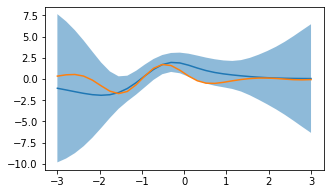

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(alpha_range, a[:,0])
plt.fill_between(alpha_range, (a[:,0] + 1.96*a[:,1]).reshape(-1), (a[:,0] - 1.96*a[:,1]).reshape(-1), alpha=0.5)
plt.plot(alpha_range, ftfa)
plt.show()

# BayesCME

In [ ]:
def mean_and_cov_for_alpha_range2(x_generated, alpha_range, M = 200):
  mean_and_cov = np.zeros((len(alpha_range), 2))
  for i, alpha in enumerate(alpha_range):
    if i % 5 == 0:
      print("number of alpha: %i", i)
    test_x = sample_from_x_with_alpha(x_generated, alpha, M)
    uope_m, uope_cov = uope.return_mean_and_covariance2(test_x, nuc_reg=nuc_reg)
    uope_std = np.sqrt(uope_cov.detach().numpy()).reshape(-1)
    mean_and_cov[i, 0] = uope_m
    mean_and_cov[i, 1] = uope_std
  return mean_and_cov


b = mean_and_cov_for_alpha_range2(x_generated, alpha_range, M = 50)

number of alpha: %i 0
number of alpha: %i 5
number of alpha: %i 10
number of alpha: %i 15
number of alpha: %i 20
number of alpha: %i 25


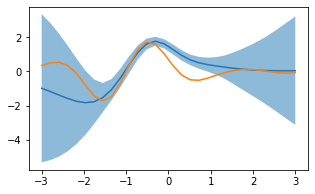

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(alpha_range, b[:,0])
plt.fill_between(alpha_range, (b[:,0] + 1.96*b[:,1]).reshape(-1), (b[:,0] - 1.96*b[:,1]).reshape(-1), alpha=0.5)
plt.plot(alpha_range, ftfa)
plt.show()

# CMP

In [ ]:
def mean_and_cov_for_alpha_range3(x_generated, alpha_range, M = 200):
  mean_and_cov = np.zeros((len(alpha_range), 2))
  for i, alpha in enumerate(alpha_range):
    if i % 5 == 0:
      print("number of alpha: %i", i)
    test_x = sample_from_x_with_alpha(x_generated, alpha, M)
    uope_m, uope_cov = uope.return_mean_and_covariance3(test_x, nuc_reg=nuc_reg)
    uope_std = np.sqrt(uope_cov.detach().numpy()).reshape(-1)
    mean_and_cov[i, 0] = uope_m
    mean_and_cov[i, 1] = uope_std
  return mean_and_cov


c = mean_and_cov_for_alpha_range3(x_generated, alpha_range, M = 50)

number of alpha: %i 0
number of alpha: %i 5
number of alpha: %i 10
number of alpha: %i 15
number of alpha: %i 20
number of alpha: %i 25


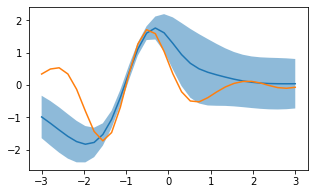

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(alpha_range, c[:,0])
plt.fill_between(alpha_range, (c[:,0] + 1.96*c[:,1]).reshape(-1), (c[:,0] - 1.96*c[:,1]).reshape(-1), alpha=0.5)
plt.plot(alpha_range, ftfa)
plt.show()

# Compare plots


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1440x432 with 0 Axes>

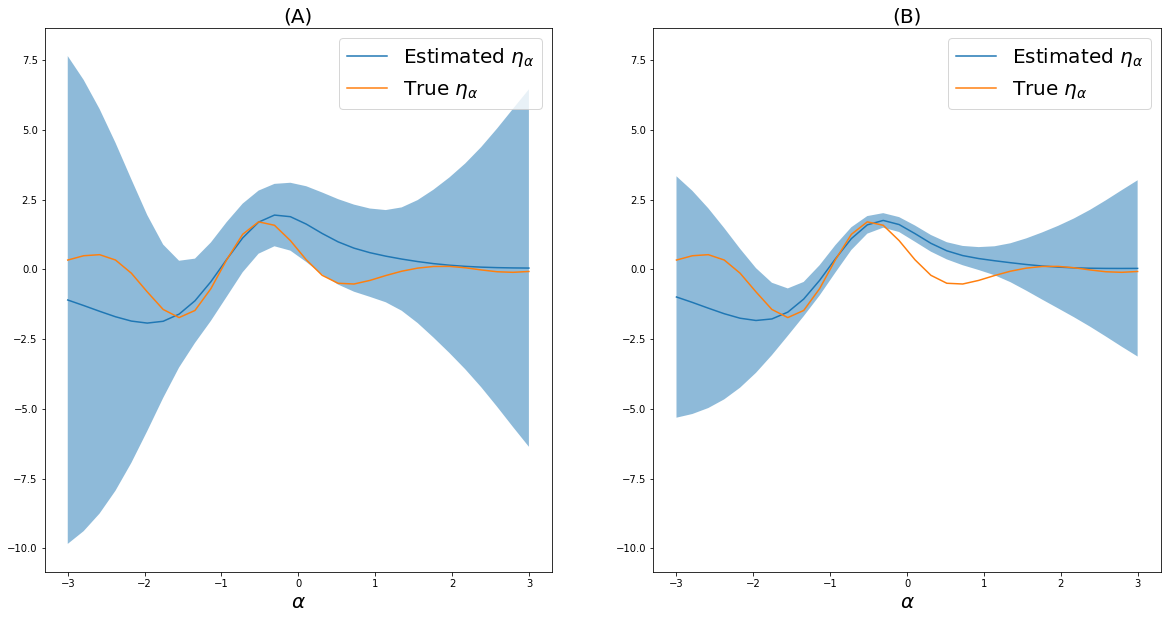

In [ ]:
# BayesCME vs BayesCMP
plt.figure()

plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(1, 2)
fontsize = 20
legendsize = 20

# Defining custom 'xlim' and 'ylim' values.
mgp = np.array([a[:,0] + 1.96*a[:,1], b[:,0] + 1.96*b[:,1]])
mmgp = np.array([a[:,0] - 1.96*a[:,1], b[:,0] - 1.96*b[:,1]])

margin = 1
custom_gplim = (np.min(mmgp) - margin, np.max(mgp) + margin)
# Setting the values for all axes.
plt.setp(axs, ylim=custom_gplim)


axs[0].plot(alpha_range, a[:,0], label = r"Estimated $\eta_{\alpha}$")
axs[0].fill_between(alpha_range, (a[:,0] + 1.96*a[:,1]).reshape(-1), (a[:,0] - 1.96*a[:,1]).reshape(-1), alpha=0.5)
axs[0].plot(alpha_range, ftfa, label = r"True $\eta_{\alpha}$")
axs[0].legend(prop={'size': legendsize})
title = '(A)'
axs[0].set_title(title, fontsize = fontsize)


axs[1].plot(alpha_range, b[:,0], label = r"Estimated $\eta_{\alpha}$")
axs[1].fill_between(alpha_range, (b[:,0] + 1.96*b[:,1]).reshape(-1), (b[:,0] - 1.96*b[:,1]).reshape(-1), alpha=0.5)
axs[1].plot(alpha_range, ftfa, label = r"True $\eta_{\alpha}$")
axs[1].legend(prop={'size': legendsize})
title = '(B)'
axs[1].set_title(title, fontsize = fontsize)

for ax in axs.flat:
    ax.set_xlabel(r'$\alpha$', fontsize=20)

plt.savefig("BayesCMP_BayesCME.png", bbox_inches='tight')
files.download("BayesCMP_BayesCME.png")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1440x720 with 0 Axes>

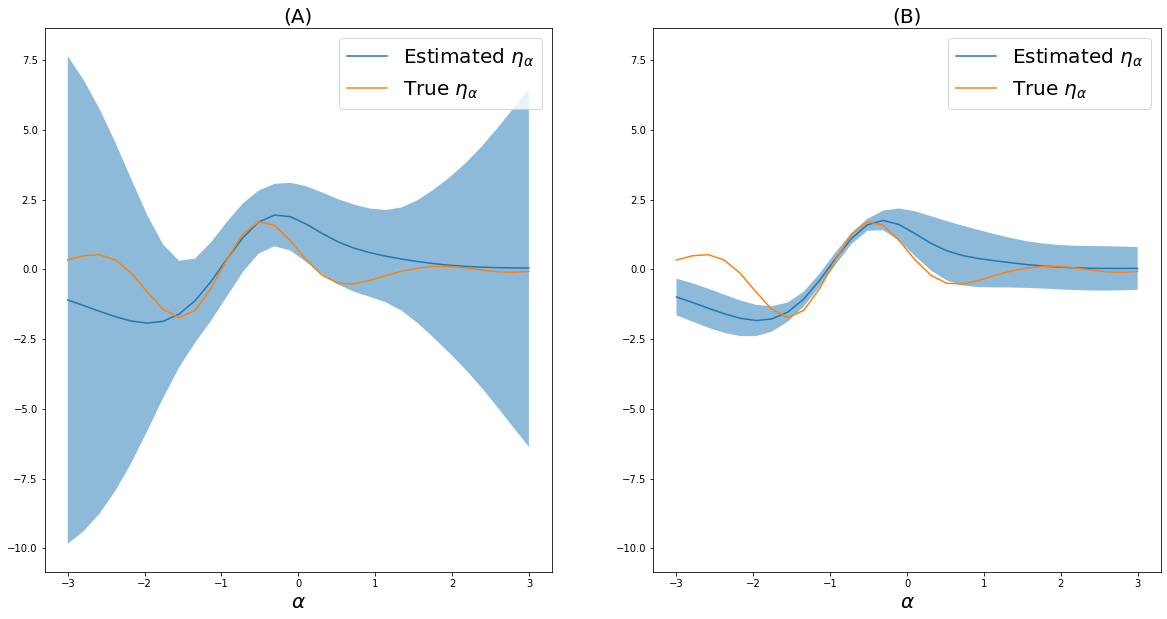

In [ ]:
# CMP vs BayesCMP
plt.figure()

plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(1, 2)
fontsize = 20
legendsize = 20

# Defining custom 'xlim' and 'ylim' values.
mgp = np.array([a[:,0] + 1.96*a[:,1], b[:,0] + 1.96*b[:,1]])
mmgp = np.array([a[:,0] - 1.96*a[:,1], b[:,0] - 1.96*b[:,1]])

margin = 1
custom_gplim = (np.min(mmgp) - margin, np.max(mgp) + margin)
# Setting the values for all axes.
plt.setp(axs, ylim=custom_gplim)


axs[0].plot(alpha_range, a[:,0], label = r"Estimated $\eta_{\alpha}$")
axs[0].fill_between(alpha_range, (a[:,0] + 1.96*a[:,1]).reshape(-1), (a[:,0] - 1.96*a[:,1]).reshape(-1), alpha=0.5)
axs[0].plot(alpha_range, ftfa, label = r"True $\eta_{\alpha}$")
axs[0].legend(prop={'size': legendsize})
title = '(A)'
axs[0].set_title(title, fontsize = fontsize)


axs[1].plot(alpha_range, c[:,0], label = r"Estimated $\eta_{\alpha}$")
axs[1].fill_between(alpha_range, (c[:,0] + 1.96*c[:,1]).reshape(-1), (c[:,0] - 1.96*c[:,1]).reshape(-1), alpha=0.5)
axs[1].plot(alpha_range, ftfa, label = r"True $\eta_{\alpha}$")
axs[1].legend(prop={'size': legendsize})
title = '(B)'
axs[1].set_title(title, fontsize = fontsize)

for ax in axs.flat:
    ax.set_xlabel(r'$\alpha$', fontsize=20)


plt.savefig("BayesCMP_CMP.png", bbox_inches='tight')
files.download("BayesCMP_CMP.png") 


<Figure size 1440x720 with 0 Axes>

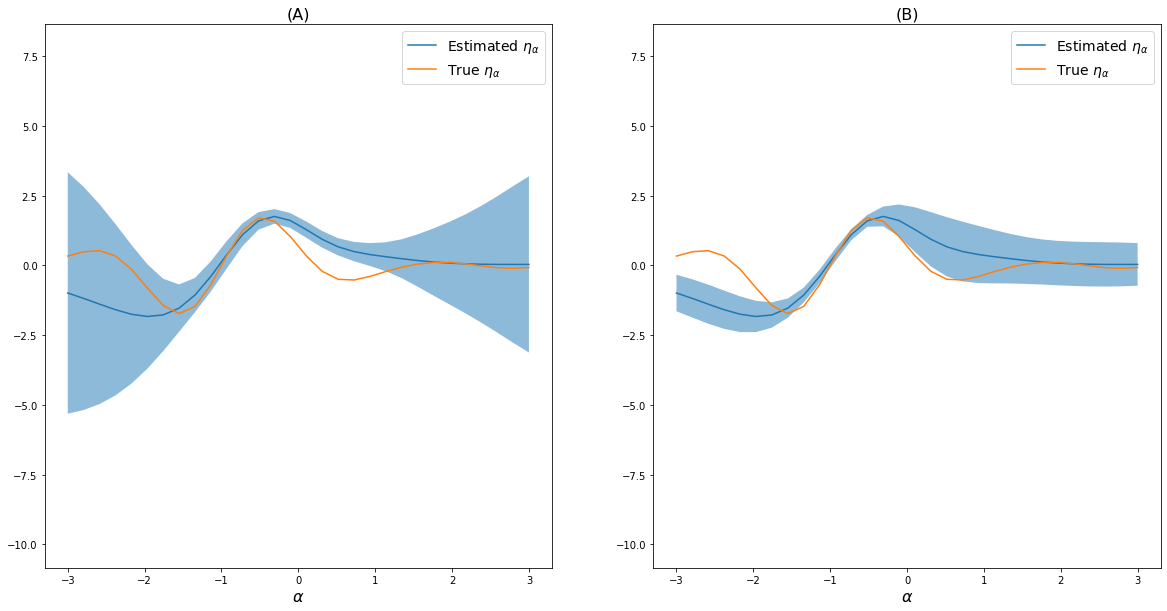

In [ ]:
# CMP vs BayesCME
plt.figure()

plt.rcParams["figure.figsize"] = (20,10)
fig, axs = plt.subplots(1, 2)
fontsize = 16
legendsize = 14

# Defining custom 'xlim' and 'ylim' values.
mgp = np.array([a[:,0] + 1.96*a[:,1], b[:,0] + 1.96*b[:,1]])
mmgp = np.array([a[:,0] - 1.96*a[:,1], b[:,0] - 1.96*b[:,1]])

margin = 1
custom_gplim = (np.min(mmgp) - margin, np.max(mgp) + margin)
# Setting the values for all axes.
plt.setp(axs, ylim=custom_gplim)


axs[0].plot(alpha_range, b[:,0], label = r"Estimated $\eta_{\alpha}$")
axs[0].fill_between(alpha_range, (b[:,0] + 1.96*b[:,1]).reshape(-1), (b[:,0] - 1.96*b[:,1]).reshape(-1), alpha=0.5)
axs[0].plot(alpha_range, ftfa, label = r"True $\eta_{\alpha}$")
axs[0].legend(prop={'size': legendsize})
title = '(A)'
axs[0].set_title(title, fontsize = fontsize)


axs[1].plot(alpha_range, c[:,0], label = r"Estimated $\eta_{\alpha}$")
axs[1].fill_between(alpha_range, (c[:,0] + 1.96*c[:,1]).reshape(-1), (c[:,0] - 1.96*c[:,1]).reshape(-1), alpha=0.5)
axs[1].plot(alpha_range, ftfa, label = r"True $\eta_{\alpha}$")
axs[1].legend(prop={'size': legendsize})
title = '(B)'
axs[1].set_title(title, fontsize = fontsize)

for ax in axs.flat:
    ax.set_xlabel(r'$\alpha$', fontsize=16)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1440x720 with 0 Axes>

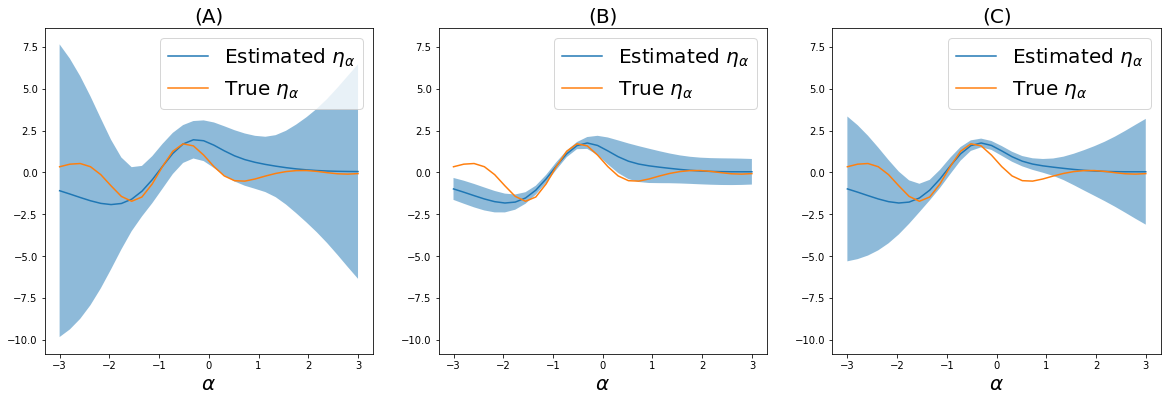

In [ ]:
# The three of them
plt.figure()

plt.rcParams["figure.figsize"] = (20,6)
fig, axs = plt.subplots(1, 3)
fontsize = 20
legendsize = 20

# Defining custom 'xlim' and 'ylim' values.
mgp = np.array([a[:,0] + 1.96*a[:,1], b[:,0] + 1.96*b[:,1], c[:,0] + 1.96*c[:,1]])
mmgp = np.array([a[:,0] - 1.96*a[:,1], b[:,0] - 1.96*b[:,1], c[:,0] + 1.96*c[:,1]])

margin = 1
custom_gplim = (np.min(mmgp) - margin, np.max(mgp) + margin)
# Setting the values for all axes.
plt.setp(axs, ylim=custom_gplim)


axs[0].plot(alpha_range, a[:,0], label = r"Estimated $\eta_{\alpha}$")
axs[0].fill_between(alpha_range, (a[:,0] + 1.96*a[:,1]).reshape(-1), (a[:,0] - 1.96*a[:,1]).reshape(-1), alpha=0.5)
axs[0].plot(alpha_range, ftfa, label = r"True $\eta_{\alpha}$")
axs[0].legend(prop={'size': legendsize})
title = '(A)'
axs[0].set_title(title, fontsize = fontsize)

axs[1].plot(alpha_range, c[:,0], label = r"Estimated $\eta_{\alpha}$")
axs[1].fill_between(alpha_range, (c[:,0] + 1.96*c[:,1]).reshape(-1), (c[:,0] - 1.96*c[:,1]).reshape(-1), alpha=0.5)
axs[1].plot(alpha_range, ftfa, label = r"True $\eta_{\alpha}$")
axs[1].legend(prop={'size': legendsize})
title = '(B)'
axs[1].set_title(title, fontsize = fontsize)

axs[2].plot(alpha_range, b[:,0], label = r"Estimated $\eta_{\alpha}$")
axs[2].fill_between(alpha_range, (b[:,0] + 1.96*b[:,1]).reshape(-1), (b[:,0] - 1.96*b[:,1]).reshape(-1), alpha=0.5)
axs[2].plot(alpha_range, ftfa, label = r"True $\eta_{\alpha}$")
axs[2].legend(prop={'size': legendsize})
title = '(C)'
axs[2].set_title(title, fontsize = fontsize)

for ax in axs.flat:
    ax.set_xlabel(r'$\alpha$', fontsize=20)


plt.savefig("THE_THREE.png", bbox_inches='tight')
files.download("THE_THREE.png") 
